In [1]:
#LOAD LIBRARIES AND READ DATA
from functions import *
thr=60#data was recorded from t=0, but the experiment does not start until t=60
Data=pd.read_excel('data/dataCl_interface_mutant.xlsx')
Data=Data[Data.time>=thr].reset_index(drop=True)

# OXA48 INTERFACE MUTANT

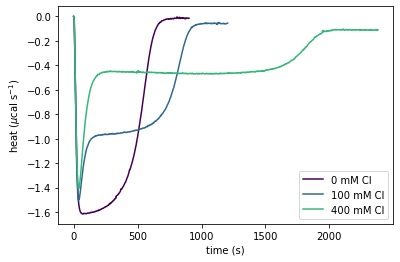

In [2]:
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
CL=[0,100,400]
CL2=[0,50,100,200,400,800]
for i,Cl in enumerate(CL):
    D=Data[Cl].dropna()
    ax.plot(D,color=cmap(CL2.index(Cl)/len(CL2)), label=str(Cl)+' mM Cl')
ax.set_xlabel('time (s)');
ax.set_ylabel('heat ($\mu$cal s$^{-1}$)');
ax.legend();
fig.savefig('figures/suppfig_dataCl_interface_mutant.pdf', bbox_inches='tight')

Cl=0 mM, c= 3.94  cal/M
Cl=100 mM, c= 3.955  cal/M
Cl=400 mM, c= 4.721  cal/M


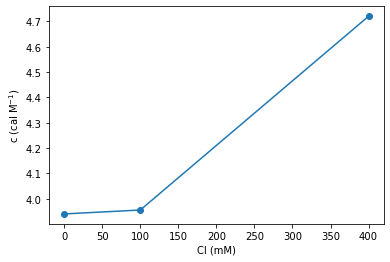

In [4]:
cV=[]
for i,Cl in enumerate(CL):
    D=Data[Cl].dropna()
    c=-auc(D)/200
    cV.append(c)
    print('Cl='+str(Cl),'mM, c=',round(c,3),' cal/M')
    
fig=plt.figure()
ax=plt.gca()
ax.plot(CL,cV,'o-')
ax.set_xlabel('Cl (mM)')
ax.set_ylabel('c (cal M$^{-1}$)');

## Fitting k1

Initial k2 4.207413981500565
The fitted parameters are k1= 0.298  and k2= 4.55


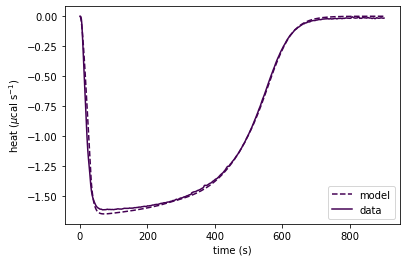

In [5]:
def fun(ParamV,D,c,k0):
    E0=0.1
    S0=200
    tf=len(D)
    y0=[0,S0,0,0]
    Params=Parameters(k0,*ParamV,0,0,0,E0)
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    E=(Hs-D)**2
    return E.mean()

E0=0.1#we simulate the model using micro molar concentrations
S0=200
D=Data[0].dropna()  
rD=realH(D)
c=getc(D,S0)
k0=30
k2=getk2(rD,c,E0)
print('Initial k2',k2)
res=minimize(fun,[1,k2],args=(D,c,k0),tol=1e-6,method='Nelder-Mead')
print('The fitted parameters are k1=',round(res.x[0],3),' and k2=',round(res.x[1],3))
tf=len(D)
y0=[0,S0,0,0]
Params=Parameters(k0,res.x[0],res.x[1],0,0,0,E0)
sol=solve_ivp(oxa,(0,tf),y0,method='Radau',max_step=0.1,args=((Params,)))
T=sol.t
C=sol.y[2,:]
H=heat(c,Params.k2,C)
Hs=measuredH(T,H)
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
ax.plot(T,Hs,'--',color=cmap(0),label='model')
ax.plot(D,color=cmap(0),label='data')
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$)')
ax.legend()

## The relationship between $k_2$ and chloride

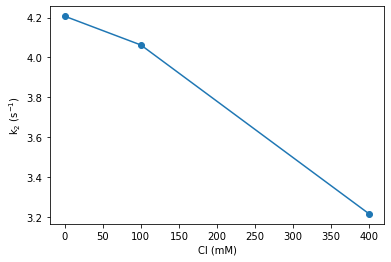

In [6]:
K2=[]
E0=100e-3
S0=200
for i,Cl in enumerate(CL):
    D=Data[Cl].dropna()
    rD=realH(D)
    c=getc(rD,S0)
    k2=getk2(rD,c,E0)
    Dmax=(-D).max()
    K2.append(k2)
#PLOT
fig=plt.figure()
ax=plt.gca()
ax.plot(CL,K2,'o-')
ax.set_xlabel('Cl (mM)')
ax.set_ylabel('k$_2$ (s$^{-1}$)');

## Finding out $k_3$

After the initial spike in heat release, most of the enzyme is in $C$ state, and suddenly heat starts going down. This is due to the reaction $C\rightarrow C_2$ kicking in, which has rate $k_3$.

Once most of the enzyme is in $C$ state, this means that $dE/dt=0$ and so $k1*E*S= k2*C$, which means that in the equation $dC/dt$ the first two terms are negligible. But also, because there is still no $C_2$ whatsoever, the last term $k_4C_2$ is also close to zero. So at this spike we have $$dC/dt \approx -k_3C.$$

In other words, $C$ will decrease exponentially at a rate $k_3$, very shortly after the spike. Because $dH/dt$ is proportional to $C$, the heat will also decrease exponentially. We can check this by plotting the data in semilog axes: if $dH/dt=A\exp(-k_3t)$, then $\log dH/dt=\log A -k_3t$, and so we should see a linear relationship between $t$ and $\log dH/dt$. This is plotted below:

100 7.864112803437886e-05 0.007864112803437885
400 2.4221632576938433e-05 0.009688653030775374


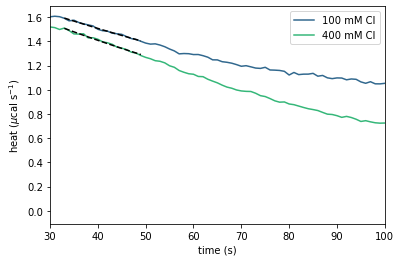

In [7]:
fig=plt.figure()
ax=plt.gca()
K3=[]
for i,Cl in enumerate(CL):
    if Cl==0:
        continue
    D=Data[Cl].dropna()
    rD=realH(D)
    xinit=33
    xend=50
    xp=range(xinit,xend)
    D1=-rD[xinit:xend]
    popt, pcov = curve_fit(line,xp,np.log(D1))
    yp=line(xp,*popt)
    K3.append(-popt[1]/Cl)
    print(Cl,K3[-1],-popt[1])
    ax.plot(-rD,color=cmap(i/len(CL)), label=str(Cl)+' mM Cl')
    ax.plot(xp,np.exp(yp),'--k')#,color=cmap(i/len(CL
ax.set_xlim([30,100]);
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$)')
ax.legend()

In [8]:
K4=[]
for i,Cl in enumerate(CL):
    if Cl==0:
        continue
    D=Data[Cl].dropna()
    rD=realH(D)
    k4=getk4(rD,K3[i-1]*Cl,Cl)
    K4.append(k4)
    print(Cl,k4)

100 1.059125639858786e-02
400 0.004281309205998257


## Fitting all parameters

0 0
[0, 3.9106540245284904, 27.48254964991333, 0.31122487266804205, 4.510029801217164, -0.00010315595892821905, 100248877.61942044, 38.80569791362209]
1 100
[100, 3.887315070963872, 21.977292828756795, 0.3422661696371073, 4.858104757565398, 0.012841596541488396, 0.015522597311807657, 21.658440520454374]
2 400
[400, 4.49023618863401, 27.886044685085594, 0.3035792845538039, 3.2974559985072185, 0.010451583033904518, 0.004722414507063427, 37.24411059784886]


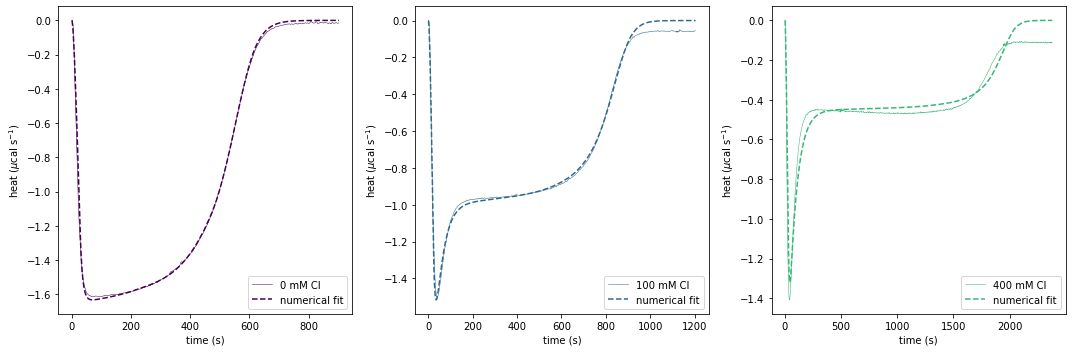

In [9]:
def fun(ParamV,D,Cl):
    E0=0.1
    S0=200
    c=ParamV[0]
    tf=len(D)
    y0=[0,S0,0,0]
    Params=Parameters(*ParamV[1::],E0)
    if Cl==0:
        Params.k3=0
        Params.k4=0
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    E=(Hs-D)**2
    return E.mean()

fig=plt.figure(figsize=(15,5))
cmap=matplotlib.cm.get_cmap('viridis')
E0=100e-3
S0=200
AP=[]
P=[]
for i,Cl in enumerate(CL):
    print(i,Cl)
    ax=fig.add_subplot(1,3,i+1)
    D=Data[Cl].dropna()
    ax.plot(D,lw=0.5,color=cmap(i/len(CL)),label=str(CL[i])+' mM Cl')
    rD=realH(D)
    c=getc(D,S0)
    k0=30
    k1=0.3
    k2=getk2(rD,c,E0)
    k3=0.01
    if Cl==0:
        k3=0
    k4=getk4(rD,k3,Cl)
    delay=37
    AP.append([Cl,c,k0,k1,k2,k3,k4,delay])
    tf=len(D)
    y0=[0,S0,0,0]
    #Fitted sim
    res=minimize(fun,[c,k0,k1,k2,k3,k4,delay],args=(D,Cl),tol=1e-6,method='Nelder-Mead')
    P.append([Cl,*res.x])
    print(P[-1])
    Params=Parameters(*res.x[1::],E0)#ParamV[0],ParamV[1],ParamV[2])
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',max_step=0.5,args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(res.x[0],Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dashed',color=cmap(i/len(CL)), label='numerical fit')
    ax.legend()
    ax.set_xlabel('time (s)')
    ax.set_ylabel('heat ($\mu$cal s$^{-1}$)')
fig.tight_layout()
fig.savefig('figures/suppfig_interface_mutant.pdf', bbox_inches='tight')

#SAVE PARAMETERS
DF=pd.DataFrame.from_records(P, columns=['Cl','c','k0','k1','k2','k3','k4','delay'])
DF.to_csv('results/interface_mutant.csv', float_format='%.4f', index=False)

[0.0, 3.9107, 27.4825, 0.3112, 4.51, -0.0001, 100248877.6194, 38.8057]
[100.0, 3.8873, 21.9773, 0.3423, 4.8581, 0.0128, 0.0155, 21.6584]
[400.0, 4.4902, 27.886, 0.3036, 3.2975, 0.0105, 0.0047, 37.2441]


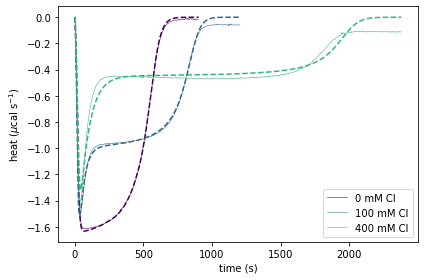

In [12]:
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
E0=100e-3
S0=200
DFP=pd.read_csv('results/interface_mutant.csv')
DFmap={}
DFmap['Time']=np.array(range(len(Data[400].dropna())))+60
for i,Cl in enumerate(CL):
    D=Data[Cl].dropna()
    ax.plot(D,lw=0.5,color=cmap(CL2.index(Cl)/len(CL2)),label=str(CL[i])+' mM Cl')
    rD=realH(D)
    P=list(DFP[DFP.Cl==Cl].iloc[0])
    print(P)
    if Cl==0:
        k3=0
        k4=0
    tf=len(D)
    y0=[0,S0,0,0]
    Params=Parameters(*P[2::],E0)
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',max_step=0.5,args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(P[1],Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dashed',color=cmap(i/len(CL)))
    ax.legend()
    ax.set_xlabel('time (s)')
    ax.set_ylabel('heat ($\mu$cal s$^{-1}$)')
    DFmap[Cl]=Hs
fig.tight_layout()
fig.savefig('figures/suppfig_interface_mutant.pdf', bbox_inches='tight')

#WRITE DATA
DF=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in DFmap.items() ]))
DF.to_excel('results/dataCl_interface_mutant.xls', engine='openpyxl', index=False)